# Project Outline

1) **Setup**: Here we import packages, set paths and load data as required. 

2) **Preprocessing from KNN/SVM**: This includes all the preprocessing steps conducted for the previous project. For convenience this entire section could be passed over. Key steps include: create an age variable, get a count of the number of comorbidities by patient, include the number of repeat visits and reduce the number of sub-categories for categorical features.  

3) **Additional preprocessing**: Since we are working with a new outcome variable ('LOS'), I undertake some quick exploratory data analysis. Due to the skewed distribution of the outcome variable interpretation of the relationship between 'LOS' and categorical features is difficult. Nevertheless, we observe some clear positive/negative correlations with respect to the numerical features. Furthermore, I calculate the min, max and IQR range of the 'LOS' by hospital admissions. 

4) **Base Learners**: Here I tune hyperparameters for a range of base learners, including linear and non-linear models. The best hyperparameters are then saved and used as inputs for the next step. 

5) **Super Learner**: I test for a range of meta learners in order to find the best super learner i.e. the meta-learner which produces the best predictions when combining the optimised base learners. 

6) **Model interpretabiity**: For the best model I undertake model interpretability in the form of global and local SHAP values. 

# Setup

## Import packages and functions

In [8]:
import os

In [9]:
#Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

## set paths

In [10]:
#google colab
#path = '/content/drive/MyDrive/CML_2_Projects/Ensembles/'
#data_path = '/content/drive/MyDrive/CML_2_Projects/Ensembles/Data/'
#submission_path = '/content/drive/MyDrive/CML_2_Projects/Ensembles/Kaggle Submission/'
#results_path = '/content/drive/MyDrive/CML_2_Projects/Ensembles/Results/'
#model_path = '/content/drive/MyDrive/CML_2_Projects/Ensembles/Models/'
#os.chdir(data_path)

In [11]:
#local
path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/CML2/Project 2/'
data_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/CML2/Project 2/Data/'
submission_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/CML2/Project 2/Kaggle submissions/'
functions_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/CML2/Project 2/Functions/'
results_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/CML2/Project 2/Results/'
model_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/CML2/Project 2/Models/'
os.chdir(data_path)

In [12]:
#%pip install category_encoders
#%pip install xgboost
#%pip install mlens
#%pip install shap

In [13]:
import pandas as pd
from mlens.ensemble import SuperLearner
import seaborn as sns
import numpy as np
import sklearn
from sklearn.svm import SVR
from sklearn import linear_model
from xgboost import XGBRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
from xgboost import plot_importance
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer
import pickle
from sklearn.impute import IterativeImputer
from functools import reduce
from sklearn.compose import make_column_selector as selector
import sklearn.feature_selection as fs
from sklearn.metrics import mean_squared_error
from math import sqrt
import shap

#%pip install category_encoders
from category_encoders import TargetEncoder, BinaryEncoder, WOEEncoder

In [14]:
from IPython.display import Image 
#%pip install pydotplus
import pydotplus
import graphviz
import datetime as dt


In [15]:
def plot_tree(clf, feature_names, target_names):
    dot_data = sklearn.tree.export_graphviz(clf, out_file=None, 
                             feature_names=feature_names,  
                             class_names= target_names,  
                             filled=True, rounded=True,  
                             special_characters=True) 
    return pydotplus.graph_from_dot_data(dot_data).create_png() 

In [16]:
def getting_dates(DOBs, ATs):
  admit_dates = []
  birthdays = []
  for i in range(0, len(DOBs)):
      birthdays.append(dt.datetime.strptime(DOBs[i], '%Y-%m-%d %H:%M:%S'))
  for j in range(0, len(ATs)):
      admit_dates.append(dt.datetime.strptime(ATs[j], '%Y-%m-%d %H:%M:%S'))
  return birthdays, admit_dates

def getting_age(birthdays, admit_dates):
  ages = []
  for i in range(0, len(birthdays)):
    ages.append(((admit_dates[i] - birthdays[i]).days)/365.25)
  return ages

def age_fix(data, feature):
    for i in range(0, len(data[feature])):
        if data.loc[i, feature] > 120:
            data.loc[i, feature] = 95
    return data

def drop_feature(features, data):
    for feature in features:
        data = data.drop(feature, axis = 1)
    return data 

def replace(data, feature_to_replace, feature_replacements, new_feature):
    data[feature_to_replace] = data[feature_to_replace].replace(feature_replacements, new_feature)
    return data


def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

## Load data

In [17]:
comorbidities = pd.read_csv('MIMIC_diagnoses.csv')
diagnosis_definitions = pd.read_csv('MIMIC_metadata_diagnose.csv')
feature_definitions = pd.read_excel('mimic_patient_metadata.xlsx')
train_data = pd.read_csv('mimic_train.csv')
test_data = pd.read_csv('mimic_test_los.csv')
SEED = 5

In [18]:
#drop features we can't use
train_data = train_data.drop(['HOSPITAL_EXPIRE_FLAG', 'DIAGNOSIS'], axis = 1)
test_data = test_data.drop('DIAGNOSIS', axis=1)

# Preprocessing from KNN/SVM

## Age

In [19]:
#create age variable for train set
DoB_train, admit_date_train = getting_dates(train_data['DOB'], train_data['ADMITTIME'])
ages = getting_age(DoB_train, admit_date_train)
train_data['AGE'] = ages
train_data = age_fix(train_data, 'AGE')

In [20]:
#create age variable for test set
DOB_test, admit_date_test = getting_dates(test_data['DOB'], test_data['ADMITTIME'])
ages = getting_age(DOB_test, admit_date_test)
test_data['AGE'] = ages
test_data = age_fix(test_data, 'AGE')

## Number of comorbidities

In [21]:
#Use group by to get the no. of comorbitidies per hospital admission
comorbidities_count = comorbidities.groupby(['SUBJECT_ID','HADM_ID'], as_index = False).agg({'ICD9_CODE': 'nunique'})
#rename columns for readability 
comorbidities_count.rename(columns={'ICD9_CODE': 'No_comorbs'}, inplace=True)
#rename columns
comorbidities.columns = ['subject_id', 'hadm_id', 'seq_num', 'ICD9_diagnosis']
comorbidities_count.columns =  ['subject_id', 'hadm_id', 'no_comorbs']

In [22]:
#merge with dataset
comorbidities.columns = ['subject_id', 'hadm_id', 'seq_num', 'ICD9_diagnosis']
train_data = train_data.merge(comorbidities_count[['subject_id', 'hadm_id', 'no_comorbs']], on=['subject_id', 'hadm_id'])
test_data = test_data.merge(comorbidities_count[['subject_id', 'hadm_id', 'no_comorbs']], on=['subject_id', 'hadm_id'])

## Repeat visits

In [23]:
#get admission time into correct format in order to calculate repeat visits
for i in range(0, len(train_data['ADMITTIME'])):
    train_data['ADMITTIME'][i] = dt.datetime.strptime(train_data['ADMITTIME'][i], "%Y-%m-%d %H:%M:%S")
    train_data['Diff'][i] = dt.timedelta(train_data['Diff'][i])
    train_data.at[i, 'ADMITTIME'] = (train_data['ADMITTIME'][i] + train_data['Diff'][i]).date()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
#get admission time into correct format in order to calculate repeat visits
for i in range(0, len(test_data['ADMITTIME'])):
    test_data['ADMITTIME'][i] = dt.datetime.strptime(test_data['ADMITTIME'][i], "%Y-%m-%d %H:%M:%S")
    test_data['Diff'][i] = dt.timedelta(test_data['Diff'][i])
    test_data.at[i, 'ADMITTIME'] = (test_data['ADMITTIME'][i] + test_data['Diff'][i]).date()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
#order data by subject id and admission time
train_data = train_data.sort_values(['subject_id', 'ADMITTIME']).reset_index(drop = True)
test_data = test_data.sort_values(['subject_id', 'ADMITTIME']).reset_index(drop = True)

In [26]:
#count of subject_id 
train_data['repeat_visits'] = train_data.groupby(['subject_id']).cumcount()+1 
test_data['repeat_visits'] = test_data.groupby(['subject_id']).cumcount()+1

## Ethnicity

In [27]:
#categorise ethnicities 
NATIVE = ['AMERICAN INDIAN/ALASKA NATIVE',
 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',  'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER']
ASIAN = ['ASIAN',
 'ASIAN - ASIAN INDIAN',
 'ASIAN - CAMBODIAN',
 'ASIAN - CHINESE',
 'ASIAN - FILIPINO',
 'ASIAN - JAPANESE',
 'ASIAN - KOREAN',
 'ASIAN - OTHER',
 'ASIAN - THAI',
 'ASIAN - VIETNAMESE']
BLACK = ['BLACK/AFRICAN',
 'BLACK/AFRICAN AMERICAN',
 'BLACK/CAPE VERDEAN',
 'BLACK/HAITIAN']
OTHER = ['CARIBBEAN ISLAND', 'OTHER', 'MIDDLE EASTERN','MULTI RACE ETHNICITY']

HISPANIC_LATINO = ['HISPANIC OR LATINO',
 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
 'HISPANIC/LATINO - COLOMBIAN',
 'HISPANIC/LATINO - CUBAN',
 'HISPANIC/LATINO - DOMINICAN',
 'HISPANIC/LATINO - GUATEMALAN',
 'HISPANIC/LATINO - HONDURAN',
 'HISPANIC/LATINO - MEXICAN',
 'HISPANIC/LATINO - PUERTO RICAN',
 'HISPANIC/LATINO - SALVADORAN', 
                   'SOUTH AMERICAN']
UNKNOWN = ['UNABLE TO OBTAIN',
 'UNKNOWN/NOT SPECIFIED']
WHITE = ['WHITE',
 'WHITE - BRAZILIAN',
 'WHITE - EASTERN EUROPEAN',
 'WHITE - OTHER EUROPEAN',
 'WHITE - RUSSIAN',
        'PORTUGUESE']
replacing_ethnicities = [NATIVE, ASIAN, BLACK, OTHER, HISPANIC_LATINO, UNKNOWN, WHITE]
replacing_ethnicities_str = ['NATIVE', 'ASIAN', 'BLACK', 'OTHER', 'HISPANIC_LATINO', 'UNKNOWN', 'WHITE']

#'PATIENT DECLINED TO ANSWER' are left as is

In [28]:
#apply categorisation of ethnicities to dataframe
counter = 0
for i in replacing_ethnicities:
    train_data = replace(train_data, 'ETHNICITY', i, replacing_ethnicities_str[counter])
    test_data = replace(test_data, 'ETHNICITY', i, replacing_ethnicities_str[counter])
    counter +=1

## Religion

In [29]:
#crude categorisation of religions to reduce dimensionality 
religion_other = ['HEBREW', 'UNITARIAN-UNIVERSALIST', 'HINDU', 'GREEK ORTHODOX',"JEHOVAH'S WITNESS", "BUDDHIST", 'MUSLIM', 'OTHER', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'ROMANIAN EAST. ORTH', '7TH DAY ADVENTIST'] 
train_data = replace(train_data, 'RELIGION', religion_other, 'OTHER')
test_data = replace(test_data, 'RELIGION', religion_other, 'OTHER')

In [30]:
train_data.columns 

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'ICD9_diagnosis', 'FIRST_CAREUNIT',
       'LOS', 'AGE', 'no_comorbs', 'repeat_visits'],
      dtype='object')

## Missing values for marital status

In [31]:
train_data['MARITAL_STATUS'].fillna('MISSING', inplace = True)
test_data['MARITAL_STATUS'].fillna('MISSING', inplace = True)
train_data['MARITAL_STATUS'].value_counts()

MARRIED              9664
SINGLE               5910
WIDOWED              2819
DIVORCED             1413
MISSING               722
SEPARATED             240
UNKNOWN (DEFAULT)     103
LIFE PARTNER           14
Name: MARITAL_STATUS, dtype: int64

## Investigate LOS

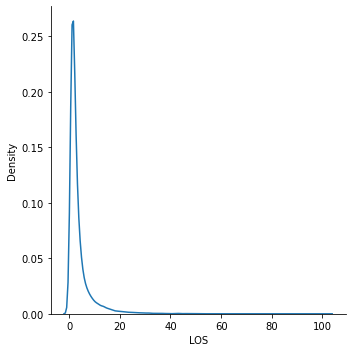

In [32]:
sns.displot(data = train_data, x = 'LOS', kind='kde')

<AxesSubplot:>

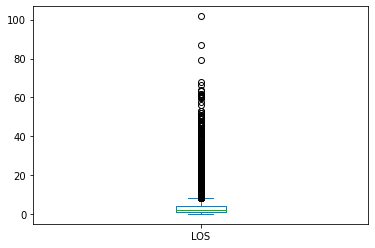

In [33]:
train_data['LOS'].plot.box()

In [34]:
train_data['LOS'].describe()

count    20885.000000
mean         3.701046
std          5.175721
min          0.056600
25%          1.165400
50%          2.020800
75%          3.915800
max        101.739000
Name: LOS, dtype: float64

In [35]:
# get 10 - 90th percentiles by intervals of 10
np.percentile(train_data['LOS'], list(range(0, 100, 10)))

array([0.0566 , 0.87984, 1.06974, 1.27612, 1.67586, 2.0208 , 2.53936,
       3.24552, 4.73736, 8.13242])

## Investigate relationship between outcome and numerical variables

In [36]:
numerical_features = list(train_data.select_dtypes(include='float64').columns)
numerical_features = numerical_features + ['no_comorbs', 'repeat_visits']

<AxesSubplot:>

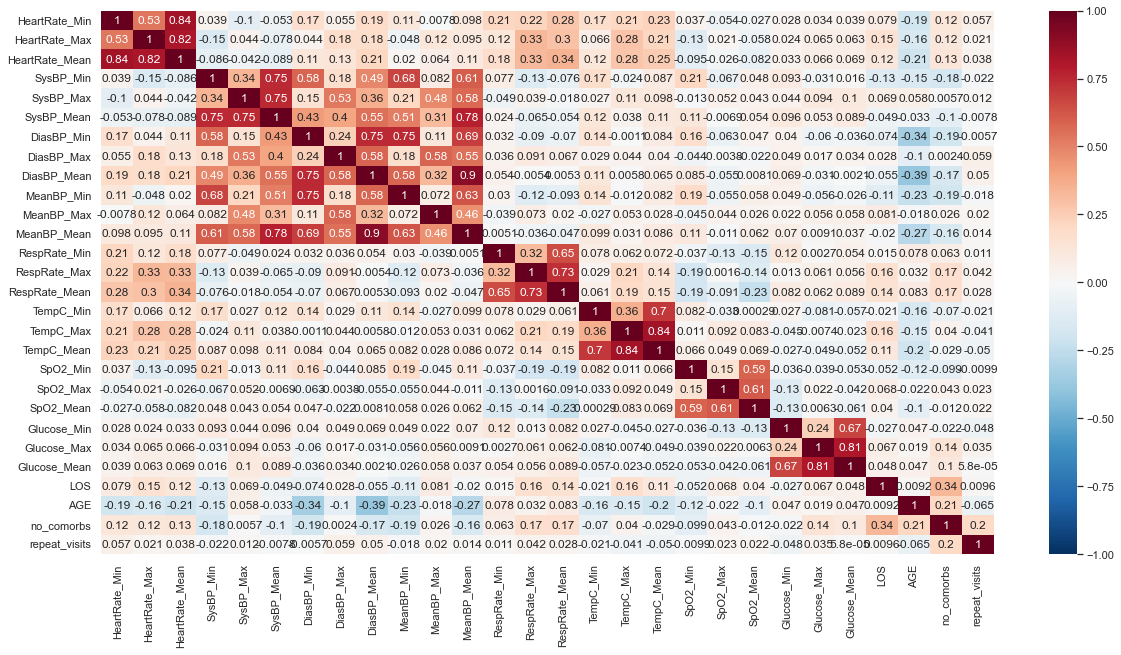

In [37]:
#plot correlation heatmap for numerical features
corr_numerical = train_data[numerical_features].corr()
sns.set(rc = {'figure.figsize':(20,10)})
sns.heatmap(corr_numerical, cmap = 'RdBu_r', linecolor = 'white', vmin=-1, vmax=1, annot = True)

In [38]:
corr_numerical['LOS'].sort_values()

SysBP_Min        -0.132064
MeanBP_Min       -0.111719
DiasBP_Min       -0.074366
DiasBP_Mean      -0.054757
SpO2_Min         -0.052424
SysBP_Mean       -0.048819
Glucose_Min      -0.027488
TempC_Min        -0.020681
MeanBP_Mean      -0.020409
AGE               0.009240
repeat_visits     0.009559
RespRate_Min      0.015433
DiasBP_Max        0.027848
SpO2_Mean         0.039658
Glucose_Mean      0.048248
Glucose_Max       0.066877
SpO2_Max          0.067647
SysBP_Max         0.068940
HeartRate_Min     0.079271
MeanBP_Max        0.081008
TempC_Mean        0.106119
HeartRate_Mean    0.116884
RespRate_Mean     0.141701
HeartRate_Max     0.150670
RespRate_Max      0.159270
TempC_Max         0.164657
no_comorbs        0.335126
LOS               1.000000
Name: LOS, dtype: float64

We observe the following: 

* A notable positive correlation for: sysBP_min and meanBP_min
* A notable negative correlation for: Strong positive correlation: tempC_mean, heartrate_mean, resprate_mean, HeartRate_Max, RespRate_Max, TempC_Max, no_comorbs
* Interestingly, neither age or repeat visits are strongly correlated with length of stay. However, the number of comorbidities shows the strongest correlation of all variables

## Investigate relationship between categorical features and outcome

In [39]:
categorical_features = list(train_data.select_dtypes(include = 'object'))
categorical_features.remove('ICD9_diagnosis')
categorical_features.remove('Diff')
categorical_features.remove('ADMITTIME')
categorical_features.remove('DOB')

In [40]:
scaler = StandardScaler()

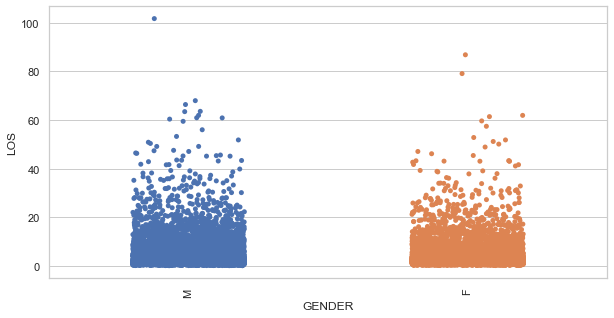

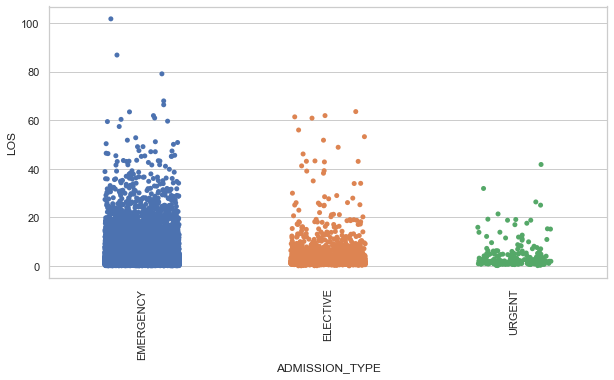

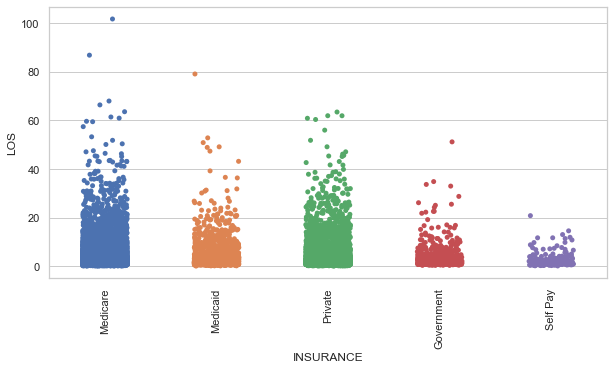

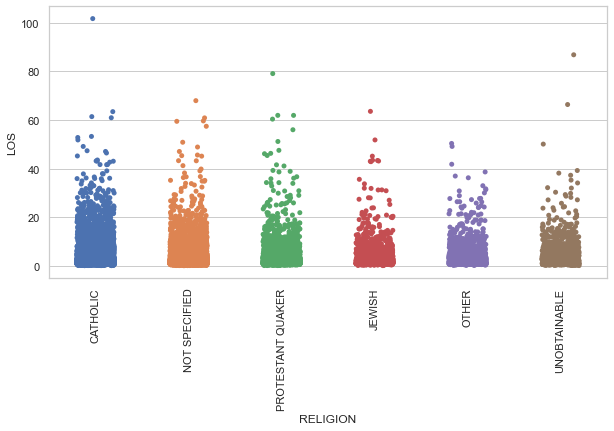

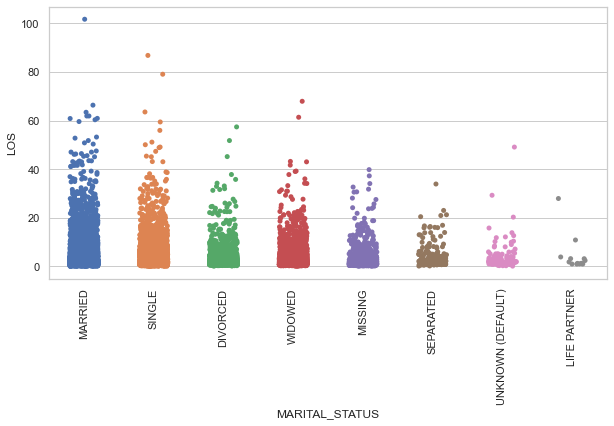

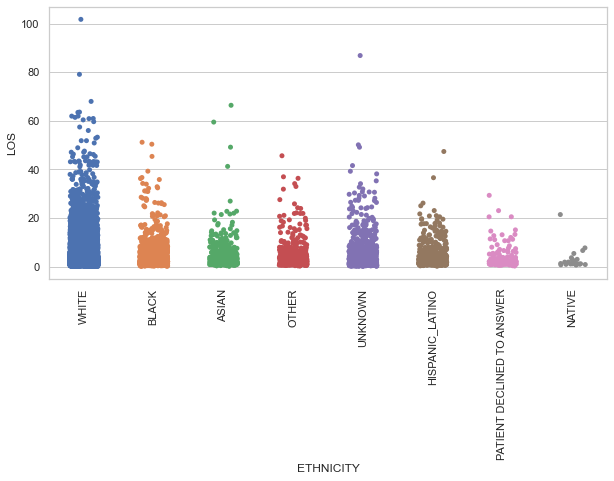

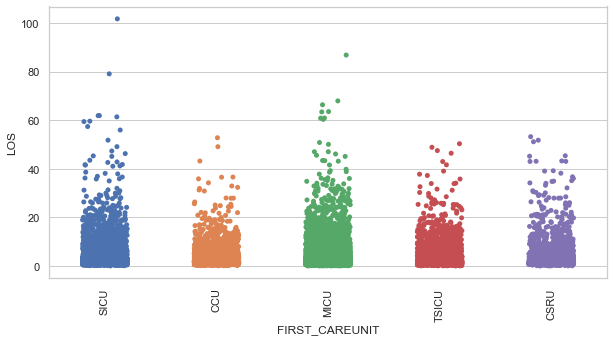

In [41]:
categorical_features_dict = dict.fromkeys(categorical_features)
sns.set_theme(style="whitegrid")
for feature in categorical_features:
    fig = plt.figure()
    fig.set_size_inches(10, 5)
    ax = sns.stripplot(x=feature, y="LOS", data=train_data, jitter=0.2)
    #plt.axhline(y=median, color='r', linestyle='-', label = 'feature_median')
    plt.xticks(rotation=90)
#    plt.show()

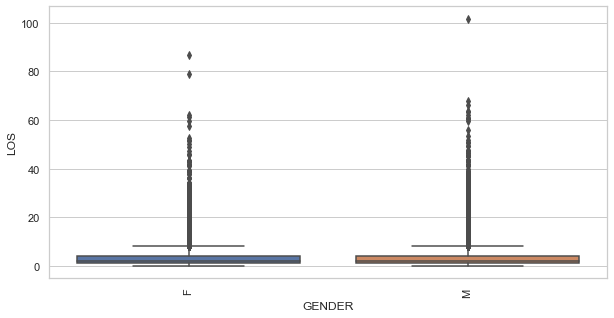

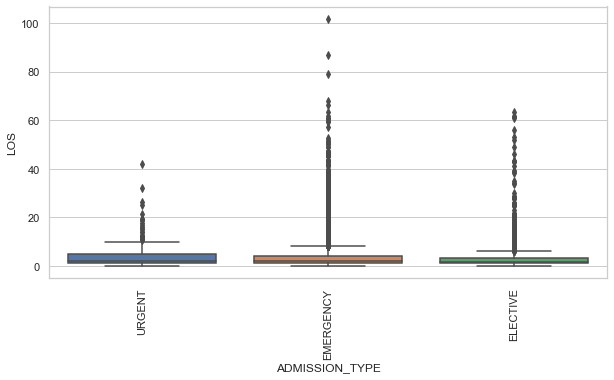

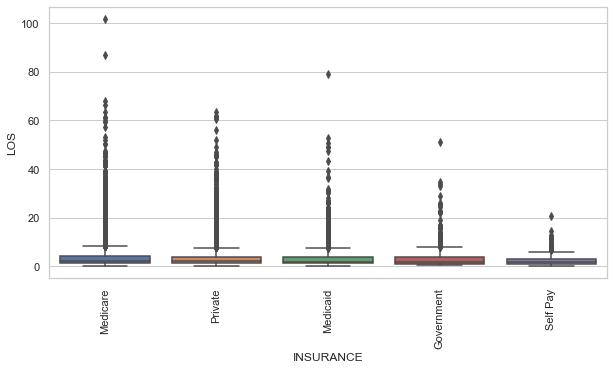

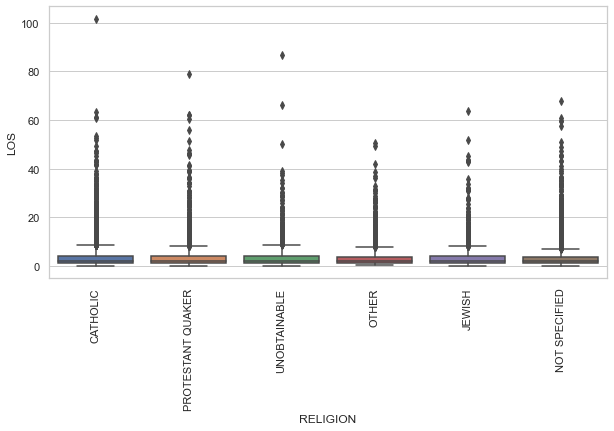

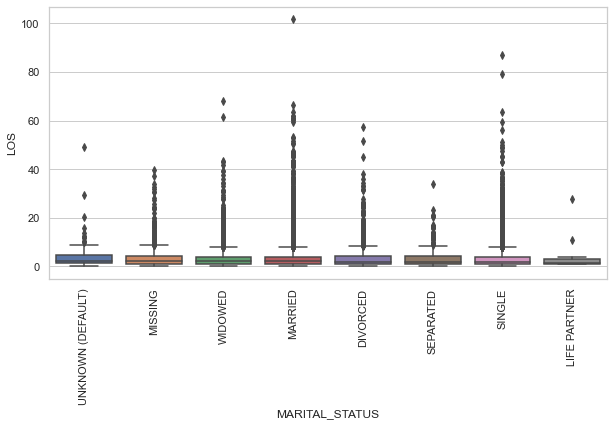

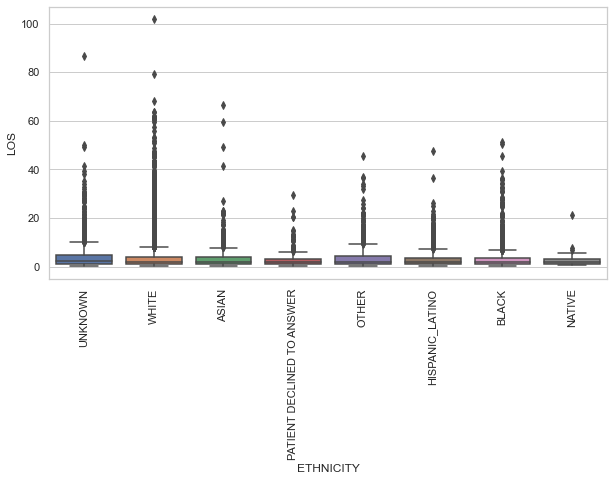

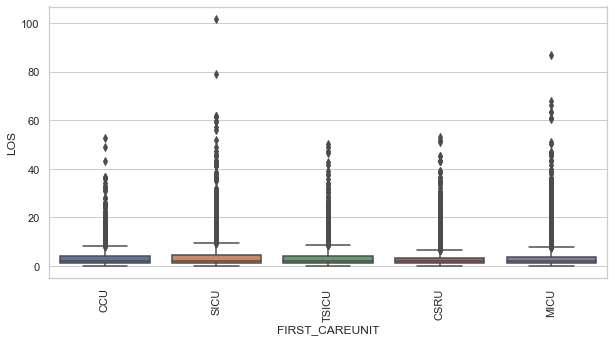

In [42]:
categorical_features_dict = dict.fromkeys(categorical_features)
sns.set_theme(style="whitegrid")
for feature in categorical_features:
    fig = plt.figure()
    fig.set_size_inches(10, 5)
    my_order = train_data.groupby(by=[feature])["LOS"].median().sort_values().iloc[::-1].index
    ax = sns.boxplot(x=feature, y="LOS", data=train_data, order = my_order)
    #plt.axhline(y=median, color='r', linestyle='-', label = 'feature_median')
    plt.xticks(rotation=90)
#    plt.show()
    #categorical_features_dict[feature] = ax

These are difficult to interpret, but we observe some variation for:

* Insurance: Self-pay individuals appear to have lower lengths of stay. 
* Admission type: Urgent cases also tend to have lower lengths of stay. 

## Diagnosis

In [43]:
diagnosis = pd.merge(comorbidities, train_data[['subject_id', 'hadm_id', 'LOS']], on = ['subject_id', 'hadm_id'], how = 'left')

In [44]:
#drop NAs because these patient hospital admissions are not in the training data. 
#Hence we cannot draw any inference about the diagnoses at these vists They are dropped. 
diagnosis = diagnosis[diagnosis['LOS'].notna()]

In [45]:
diagnosis['ICD9_diagnosis'].value_counts().describe()

count    5389.000000
mean       57.504917
std       279.418062
min         1.000000
25%         2.000000
50%         5.000000
75%        21.000000
max      8502.000000
Name: ICD9_diagnosis, dtype: float64

Some diagnosis appear a lot

In [46]:
#construct dataframe - distribution of LOS  by ICD9 code
total_diagnosed = diagnosis['ICD9_diagnosis'].value_counts().reset_index().rename(columns = {'ICD9_diagnosis': 'no_diagnosed', 'index': 'ICD9_diagnosis'})
min_LOS = diagnosis.groupby('ICD9_diagnosis').agg({'LOS': 'min'}).sort_values(by = 'LOS', ascending = False).rename(columns = {'LOS': 'min_LOS'}).reset_index()
lqr_LOS = diagnosis.groupby('ICD9_diagnosis').agg({'LOS': percentile(25)}).sort_values(by = 'LOS', ascending = False).rename(columns = {'LOS': 'lqr_LOS'}).reset_index()
median_LOS = diagnosis.groupby('ICD9_diagnosis').agg({'LOS': 'median'}).sort_values(by = 'LOS', ascending = False).rename(columns = {'LOS': 'median_LOS'}).reset_index()
uqr_LOS =  diagnosis.groupby('ICD9_diagnosis').agg({'LOS': percentile(75)}).sort_values(by = 'LOS', ascending = False).rename(columns = {'LOS': 'uqr_LOS'}).reset_index()
max_LOS = diagnosis.groupby('ICD9_diagnosis').agg({'LOS': 'max'}).sort_values(by = 'LOS', ascending = False).rename(columns = {'LOS': 'max_LOS'}).reset_index()


diagnosis_calcs = [total_diagnosed, 
                   min_LOS,
                   lqr_LOS, 
                   median_LOS,
                   uqr_LOS, 
                   max_LOS]
diagnosis_calcs = reduce(lambda  left,right: pd.merge(left,right,on=['ICD9_diagnosis'],
                                            how='outer'), diagnosis_calcs)

thresh = 0
diagnosis_calcs[diagnosis_calcs['no_diagnosed']>thresh].sort_values(by='median_LOS', ascending = 'False').tail(30)

,ICD9_diagnosis,no_diagnosed,min_LOS,lqr_LOS,median_LOS,uqr_LOS,max_LOS
2757,95893,5,3.7828,7.516800,26.27360,28.180500,39.0795
4809,64244,1,26.3979,26.397900,26.39790,26.397900,26.3979
4808,64934,1,26.3979,26.397900,26.39790,26.397900,26.3979
4038,8055,2,10.0107,18.263925,26.51715,34.770375,43.0236
3525,4808,2,19.0691,22.868325,26.66755,30.466775,34.2660
4161,2540,1,27.1358,27.135800,27.13580,27.135800,27.1358
5360,9063,1,27.1633,27.163300,27.16330,27.163300,27.1633
4980,74601,1,27.2688,27.268800,27.26880,27.268800,27.2688
4162,05443,1,27.3981,27.398100,27.39810,27.398100,27.3981
5065,5071,1,28.1273,28.127300,28.12730,28.127300,28.1273


In [47]:
comorbidities = pd.merge(comorbidities, diagnosis_calcs.drop(['no_diagnosed'], axis=1), on = 'ICD9_diagnosis', how = 'left')
#get min, mean, median and max_LOS by hospital admission
comorbidities = comorbidities.groupby(['subject_id', 'hadm_id']).agg({'min_LOS': 'min',
                                                                      'lqr_LOS':'median',
                                                                       'median_LOS': 'median', 
                                                                        'uqr_LOS': 'median', 
                                                                      'max_LOS':'max'}).reset_index()





In [48]:
#merge to train and test data
train_data = pd.merge(train_data, comorbidities[['subject_id', 
                                                 'hadm_id', 
                                                 'min_LOS', 
                                                 'lqr_LOS', 
                                                 'median_LOS', 
                                                 'uqr_LOS',
                                                 'max_LOS']], how = 'left', on = ['subject_id', 'hadm_id'])
test_data = pd.merge(test_data, comorbidities[['subject_id', 
                                                 'hadm_id', 
                                                 'min_LOS', 
                                                 'lqr_LOS', 
                                                 'median_LOS', 
                                                 'uqr_LOS',
                                                 'max_LOS']], how = 'left', on = ['subject_id', 'hadm_id'])




# Set up preprocessing pipeline

## Edit dtypes and drop irrelevant columns

In [49]:
#edit dtypes for easy feature allocation and drop irrelevant columns
train_data = train_data.astype({'no_comorbs': float, 'repeat_visits':float}) #changing format for preprocessor
test_data = test_data.astype({'no_comorbs': float, 'repeat_visits':float}) #changing format for preprocessor
y_train = train_data['LOS']
train_data = train_data.drop(['DOB', 'Diff', 'ADMITTIME', 'ICD9_diagnosis', 'LOS'], axis = 1) #remove irrelevant columns and target
test_data = test_data.drop(['DOB', 'Diff', 'ADMITTIME', 'ICD9_diagnosis'], axis = 1)


In [50]:
#quick check
train_data.columns == test_data.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [51]:
#quick check
#train_data.dtypes
#test_data.dtypes

## Imputers

In [52]:
#simple
numerical_transformer_simple = Pipeline(steps=[("scaler", RobustScaler()), 
           ("imputer", SimpleImputer(missing_values = np.nan, strategy = 'mean', add_indicator=True))])

#KNN 
numerical_transformer_KNN = Pipeline(steps=[("scaler", RobustScaler()), 
           ("imputer", KNNImputer(n_neighbors = 100, missing_values=np.nan, weights = 'distance', add_indicator = True))])


#iterative - starting from glucose since this has the fewest missing values. 
numerical_transformer_iterative = Pipeline(steps=[("scaler", RobustScaler()), 
           ("imputer", IterativeImputer(random_state=0, missing_values = np.nan, initial_strategy = 'mean', max_iter=1000,imputation_order = 'ascending', add_indicator=True))])

#dictionary of imputers
imputers = {'simple': numerical_transformer_simple, 'KNN': numerical_transformer_KNN, 'iterative': numerical_transformer_iterative}




In [53]:
#option to grid search over imputer parameters
imputer_grid = {'preprocessor__num__imputer__n_neighbors': [5, 10, 50, 100, 200]}

## Encoders

In [54]:
#one-hot
categorical_transformer_one_hot = OneHotEncoder(drop='if_binary', handle_unknown="ignore") #set handle_unknown to ignore, since if it encounters an unseen categorical type in the test set, it will automatically create a column of 0s 
#target encoding
categorical_transformer_target = TargetEncoder(smoothing = 1)

#dictionary of encoders
encoders = {}
encoders = {'one_hot': categorical_transformer_one_hot, 'target' : categorical_transformer_target}

In [55]:
#option to grid search over encoder parameters
encoder_grid = {'preprocessor__cat__smoothing': [1, 1.5, 2, 3, 5],
               'preprocessor__cat__min_samples_leaf': [1, 5, 10, 20, 30]}

## Preprocessing summary

In [56]:
#select imputer 
chosen_imputer = 'KNN'
imputer = imputers[chosen_imputer]
#select encoder 
chosen_encoder = 'one_hot'
encoder = encoders[chosen_encoder]

In [57]:
##preprocessing summary
identifiers = ['subject_id', 'hadm_id', 'icustay_id']
target = 'LOS'
numerical_features = list(train_data.select_dtypes(include='float64').columns)
categorical_features = list(train_data.select_dtypes(include='object').columns)

#final preprocessor for pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", imputer, numerical_features), 
        ("cat", encoder, categorical_features),
    ]
)

The preprocessing steps can thus be summarised as follows:
* 1) First scale the data using RobustScaler (i.e. median) - doing this before imputing avoids using information that is not present in the data to scale. Then impute missing values using either KNN, iterative imputer or simple mean/median. I use the KNN imputer with 100 neighbours. 
* 2) Encode categorical variables using either one_hot encoding or target encoding. Target encoding often led to overfitting so I used the one_hot encoder mostly. I would have liked to have tried the target encoder with a range of smoothing values as a way of regualirizing and reducing the potential to overfit. However, currently this cannot be included in the pipeline. 

# Baseline Learners

Ensembling is a technique that attempts to combine different models in order to improve prediciton. The intuition is that different algorithms are able to capture different parts of the underlying structure of the data. For this reason I include a combination of linear (Lasso) and non-linear models (Decision Trees, Random Forest) and conduct hyperparameter optimisation.

Note that below is a bit messy because of the number of models. I typically list all the hyperparameters for tuning and some reasonable ranges which help when flexing the choice. Only the optimised hyperparameters are included in the final lists. 

## Lasso hyperparameters

In [115]:
#Lasso params
lasso_params = {'regressor__alpha': [0.01]} #[0.01, 0.1, 1, 10]

## SVR hyperparameters

In [52]:
#SVR params - note this was not run due to computational constraints
svr_params = {'regressor__C':[0.01, 0.1], #, 1, 10]
              'regressor__gamma':[0.01, 0.1, 1, 10],
              'regressor__kernel': ['linear', 'rbf'],
              }

## Decision Tree and Random Forest hyperparameters

In [116]:
##DT hyperparameters 


##full list for easy flexing

#'regressor__max_depth': [20, 30, 40], 
#'regressor__min_samples_split' = [2, 3, 5, 8, 15] 
#'regressor__min_samples_leaf' : [2, 5, 10], #[2, 5, 8, 15, 25, 50] 
#'regressor__max_features': ['auto', 'sqrt', 'log2'],
#'regressor__max_leaf_nodes: [None,10,20,30,50, 75]'
#'regressor__ccp_alpha': [0.15], #[0.0001, 0.001, 0.01, 0.1, 1, 10]
#'regressor__min_impurity_decrease': [0.00025,0.0005,0.00075, 0.01, 0.02, 0.03] 


#try pruning together with max leaf nodes
dt_params = {#'regressor__max_depth': [2, 3, 6, 10], #let the tree be as deep as possible and use pruning instead
            #'regressor__min_samples_split' : [2, 3, 5, 8, 15], #very similar to min_samples_leaf so these weren't tried together
            'regressor__min_samples_leaf' : [15],  #[5, 10, 15], 
              'regressor__max_features': ['auto'],  #'sqrt', 'log2'], 
              'regressor__max_leaf_nodes': [10],      #[None,10,30,50],
             'regressor__ccp_alpha':  [0],   #, 0.01, 0.1, 1, 2], #cost complexity parameter - explained below
    'regressor__random_state': [SEED],
                #'regressor__min_impurity_decrease': [0.001,0.01,0.1, 1, 10] #analogous to pruning/max_leaf_nodes so not grid searched
}

In [118]:
## Random Forest hyperparameters

##full list for easy flexing


#'regressor__n_estimators': [10, 50, 100]
#'regressor__max_depth': [20, 30, 40], #let the tree be as deep as possible and use pruning instead
#'regressor__min_samples_split' = [2, 3, 5, 8, 15] not grid searched since it is very similar to min_sample_leaf
#'regressor__min_samples_leaf' : [2, 5, 10], #[2, 5, 8, 15, 25, 50] 
#'regressor__max_leaf_nodes: [None,10,20,30,50, 75]'
#'regressor__max_features': ['auto', 'sqrt', 'log2'],
#'regressor__max_leaf_nodes: [None,10,20,30,50, 75]'
#'regressor__ccp_alpha': [0.15], #[0.0001, 0.001, 0.01, 0.1, 1, 10]
#'regressor__min_impurity_decrease': [0.00025,0.0005,0.00075, 0.01, 0.02, 0.03] 
#'regressor__max_samples': [0.1, 0.25, 0.5, 0.75, 1]



rf_params = {#'regressor__max_depth': [4, 5,6, 7], 
             'regressor__max_features': ['auto'],  #, 'sqrt', 'log2'], 
             'regressor__min_samples_leaf': [15], #[5, 10, 
             'regressor__n_estimators' : [50],  # 100, 150],
    'regressor__max_leaf_nodes':  [None], #[None,10,30,50],
             'regressor__random_state': [SEED],
             'regressor__ccp_alpha': [0],   #[0, 0.01, 0.1, 1, 2] 
             }



## XGBoost hyperparameters

In [119]:
## XGBoost hyperparameters

 #{'regressor__objective':['reg:squarederror'],
             # 'regressor__eval_metric':['rmse'],
              #'regressor__learning_rate': [0.1, 0.5, 0.9],
              #'regressor__gamma': [0.1, 1, 10],
              #  'regressor__max_depth': [2, 6, 10],
              #'regressor__min_child_weight' : [0.1, 1, 10],
               #   'regressor__lambda':[0.1, 1]
               #  
            
            
xgb_params = {'regressor__objective':['reg:squarederror'],
    'regressor__eval_metric': ['rmse'], 
                 'regressor__gamma': [1],    #[0.5, 1, 5], #penalises complexity
                 'regressor__lambda':  [0.5],  #[0.5, 1, 5], #penalises complexity
                 'regressor__learning_rate': [0.1],  #, 0.5, 0.9], 
                 'regressor__max_depth': [2],     #[2, 5, 8], 
                 'regressor__min_child_weight': [5], #[2, 5, 8],
              'regressor__n_estimators': [100], #[50, 100, 150]
             }
#xgb_params =  

#{'regressor__eval_metric': 'rmse', 'regressor__gamma': 0.1, 
# 'regressor__lambda': 0.8, 'regressor__learning_rate': 0.2, 
# 'regressor__max_depth': 2, 'regressor__min_child_weight': 3, 
 #'regressor__objective': 'reg:squarederror'}


## Grid search for all base learners

**Justification for hyperparameters**

With regard to the DT and RF, the choice of hyper-parameters to tune is difficult. I justify the choice of hyperparameters on the basis that:
* We let the tree grow as deep as possible, but set some constraints on the minimum number of samples in each leaf (to avoid "pure nodes" which will almost certainly lead to overfit. 
* Max leaf nodes results the tree forming in a 'first-best fashion' i.e. select the leafs that achieve the best relative reduction in impurity up to a maximum number of leaf nodes. 
* Finally, I prune using the cost complexity parameter. Essentially this penalises the tree for over-complexity - the sum of squared residuals is computed for the full tree plus for those where nodes = are removed, alongside an additional penalty for complexity. Hence extremely high-values for complexity would give a tree with just one leaf, whereas extremely low values would give the most complex tree. This seems appropriate to combine with the above (grow the tree up to a maximum number of nodes and then "prune" those that are not adding exta information). 

Finally for XGBoost: 

* The number of hyperparameters to optimise over is very large. As a result I set a reasonable range for each in the first instance (e.g. mostly [0.01, 0.1, 1, 10] and then narrow down the range based on the results. 
* Similarly to the DT and RF, the gamma and lambda parameters are key to avoid overfitting. 

In [120]:
#select models

models = [#SVR(), #took too long to run
          linear_model.Lasso(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          XGBRegressor(),
          ]

# models parameters

params = [#svr_params, 
          lasso_params,
        dt_params,
          rf_params, 
          xgb_params
          ]
names = [#'SVR', 
         'Lasso', 
        'DT',
         'RF', 
         'XGB'
         ]
#scores = {}



In [121]:
# gridsearch over all base learners
for i, model in enumerate(models):
    print("Grid-Searching for model:", names[i])
    #set pipeline and grid search
    pipeline = Pipeline([("preprocessor", preprocessor), 
                        ("regressor", model)])
    best_model = HalvingGridSearchCV(pipeline, params[i], scoring = 'neg_root_mean_squared_error',
                               cv = 5, verbose = 3) 
    #fit model
    best_model.fit(train_data[numerical_features + categorical_features], np.ravel(y_train))
    print(f"Best model fitted")
    #make predictions on training data and get in-sample RMSE
    train_pred = best_model.predict(train_data[numerical_features + categorical_features])
    rmse = sqrt(mean_squared_error(y_train, train_pred))
    #assign the best parameters to my models
    a = {}
    for k,v in best_model.best_params_.items():
        a[str.replace(k, 'regressor__', '')] = v
    
    #print and save in-sample and out-of-sample scores 
    models[i].set_params(**a)
    scores[names[i]] = (best_model.best_estimator_, rmse ,best_model.best_score_, best_model.best_params_)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} RMSE score for grid_search cv : {best_model.best_score_}')
    print(f'{names[i]} RMSE score on training data: {rmse}\n')
    # save model in case it stops running
    os.chdir(model_path)
    filename = names[i] + '_3' + '.sav'
    pickle.dump(best_model, open(filename, 'wb'))
    
    test_pred = best_model.predict(test_data[numerical_features+categorical_features])
    
    # Produce .csv for kaggle testing 
    os.chdir(submission_path)
    test_predictions_submit = pd.DataFrame({"icustay_id": test_data["icustay_id"], "LOS": test_pred})
    test_predictions_submit.to_csv("test_predictions_submit_" + names[i] + ".csv", index = False)  
    

    

Grid-Searching for model: Lasso
n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 20885
max_resources_: 20885
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 20885
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END regressor__alpha=0.01;, score=(train=-4.273, test=-4.642) total time=  28.7s
[CV 2/5] END regressor__alpha=0.01;, score=(train=-4.387, test=-4.184) total time=  22.8s
[CV 3/5] END regressor__alpha=0.01;, score=(train=-4.409, test=-4.091) total time=  56.6s
[CV 4/5] END regressor__alpha=0.01;, score=(train=-4.274, test=-4.630) total time=  57.9s
[CV 5/5] END regressor__alpha=0.01;, score=(train=-4.371, test=-4.251) total time= 1.3min
Best model fitted
Lasso chosen hyperparameters: {'regressor__alpha': 0.01}
Lasso RMSE score for grid_search cv : -4.359562957762133
Lasso RMSE score on training data: 4.345634691223087

Grid-Searching for model: DT
n_iterations: 1
n_required_iterations: 1

Text(0.5, 1.0, 'Best base learners')

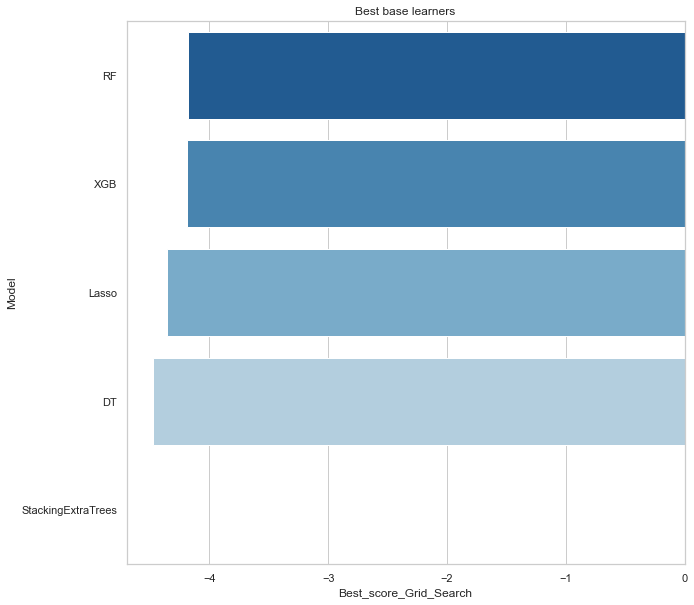

In [122]:
# look at ranking in terms of out of sample score for the base learners
ranking = pd.DataFrame.from_dict(scores, orient='index').reset_index()
#compare model rankings
ranking.columns = ['Model', 'Setting', 'In-Sample RMSE', 'Best_score_Grid_Search', 'Best_params']
ranking = ranking.sort_values(by='Best_score_Grid_Search', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x="Best_score_Grid_Search", y="Model", data=ranking, ax=ax, palette = 'Blues_r').set_title('Best base learners')

In [123]:
ranking

,Model,Setting,In-Sample RMSE,Best_score_Grid_Search,Best_params
0,RF,"(ColumnTransformer(transformers=[('num',\n ...",3.456742,-4.179793,"{'regressor__ccp_alpha': 0, 'regressor__max_fe..."
1,XGB,"(ColumnTransformer(transformers=[('num',\n ...",4.053447,-4.188530,"{'regressor__eval_metric': 'rmse', 'regressor_..."
2,Lasso,"(ColumnTransformer(transformers=[('num',\n ...",4.345635,-4.359563,{'regressor__alpha': 0.01}
3,DT,"(ColumnTransformer(transformers=[('num',\n ...",4.309404,-4.473868,"{'regressor__ccp_alpha': 0, 'regressor__max_fe..."
4,StackingExtraTrees,"(ColumnTransformer(transformers=[('num',\n ...",4.886279,NaN,None


The Lasso does not actually perform too badly (better than the DT!), indicating that there may be some underlying linear structure within the data that should be captured. Observing the dataframe (i.e. in-sample vs grid search best score which is the best mean test score across fits), we see that the Random Forest is clearly overfitting (perhaps because the best parameters from the grid search returns a cost complexity parameter of 0). In an ideal world I would have continued to optimise hyperparameters for the XGBoost and RF, but was time constrained. 

Now let's feed these optimised models into the super learner. 

# Meta-learners and stacking

Now we use the mlens package to undertake stacking. The purpose of stacking is to use the predictions from our base learners to build a new model - a super learner. Note that only an "in-sample" prediction is reported since cross-validated predictions are used to build the super learner.

No grid search is computed over the meta learners. Actually I wasn't sure on the intuition here so would welcome a pointer, but I presume the answer is yes you can optimise over the meta learners like any other algorithm to improve predictions. Sorry, just didn't have time! 

In [124]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

#set meta learners (including base learner for AdaBoost)
ada_base = DecisionTreeRegressor(max_depth = 5, max_features = 'sqrt',max_leaf_nodes = 15, random_state=SEED)
meta_learners = [
    ExtraTreesRegressor(n_estimators=100, max_features='sqrt', bootstrap=True, random_state=SEED),
    RandomForestRegressor(n_estimators=100, max_features='sqrt', bootstrap=True, random_state=SEED),
    AdaBoostRegressor(ada_base, n_estimators = 100, learning_rate=0.1, random_state=SEED) 
]  



meta_learners_ = ['ExtraTrees', 'RandomForest', 'GradientBoosting']

#loop over meta learners
for i, meta_learner in enumerate(meta_learners):
    #instantiate super learner
    super_learner = SuperLearner(folds=5, random_state=SEED, backend = 'threading')
    #add optimised base learners
    super_learner.add(models)
    #add meta learner
    super_learner.add_meta(meta_learner)
    
    #set up pipeline
    super_pipeline = Pipeline([("preprocessor", preprocessor), 
                        ("regressor", super_learner)])
    
    print(f"Meta-learner {meta_learners_[i]}...")
    #fit model
    super_pipeline.fit(train_data[numerical_features + categorical_features], np.ravel(y_train))
    
    #get in-sample predictions and RMSE
    in_sample_pred_super = super_pipeline.predict(train_data[numerical_features + categorical_features])
    rmse_super = sqrt(mean_squared_error(y_train, in_sample_pred_super))
    
    #predict on test-set for Kaggle
    test_pred = super_pipeline.predict(test_data[numerical_features+categorical_features])
    
    #save model and in-sample score to dictionary
    scores[f'Stacking{meta_learners_[i]}'] = (super_pipeline, rmse_super) 
                                              
    print(f'Super Learner with {meta_learners_[i]} RMSE score on train sample: {rmse_super}')

    # Produce .csv for kaggle testing 
    os.chdir(submission_path)
    test_predictions_submit = pd.DataFrame({"icustay_id": test_data["icustay_id"], "LOS": test_pred})
    test_predictions_submit.to_csv("test_predictions_submit_" + meta_learners_[i] + ".csv", index = False)  


Meta-learner ExtraTrees...
Super Learner with ExtraTrees RMSE score on train sample: 3.9886474138200305
Meta-learner RandomForest...
Super Learner with RandomForest RMSE score on train sample: 3.986594064128922
Meta-learner GradientBoosting...
Super Learner with GradientBoosting RMSE score on train sample: 4.673874743576125


# Results

Text(0.5, 1.0, 'Super learners and base learner comparison')

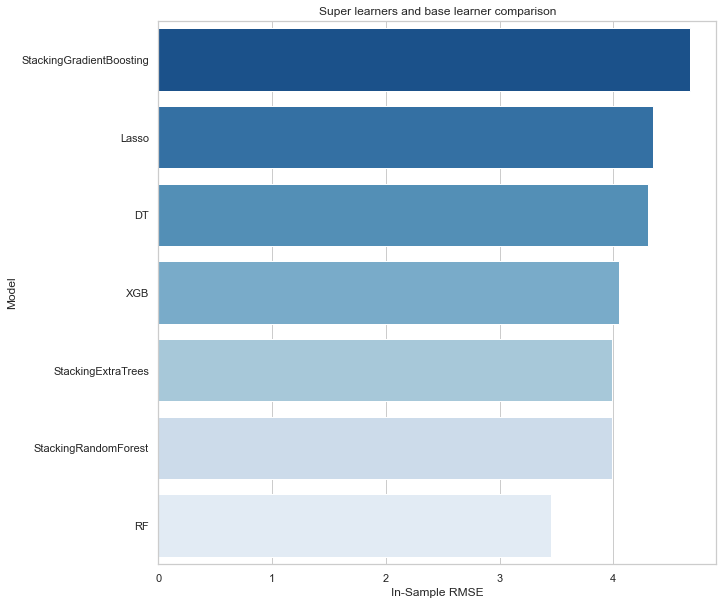

In [127]:
# observe ranking of super learners and base learners. Note that we do not compute an out of sample CV score for 
# the super-learners as noted previously. 
ranking = pd.DataFrame.from_dict(scores, orient='index').reset_index()
ranking.columns = ['Model', 'Setting', 'In-Sample RMSE', 'Grid_search_best_score_if_applicable', 'Best_params']
ranking = ranking.sort_values(by='In-Sample RMSE', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x='In-Sample RMSE', y="Model", data=ranking, ax=ax, palette = 'Blues_r').set_title('Super learners and base learner comparison')

So the Stacking ExtraTrees and Stacking Random Forest lead to a very marginal improvement in the in-sample prediction. 

In [128]:
# save model for best meta/super learner
os.chdir(model_path)
filename = 'SL_2.sav'
pickle.dump(best_model, open(filename, 'wb'))

# Model interpretability

## Load and fit best model

In [75]:
#model_path = '/content/drive/MyDrive/CML_2_Projects/Ensembles/Models/'
model_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/CML2/Project 2/Models/'
os.chdir(model_path)
models = ['RF_3.sav']
loaded_model = pickle.load(open(models[0], 'rb'))  

Note that none of the super learners improved predicitons on Kaggle. I was having real trouble loading the XGBoost, so I use the random forest to demonstrate interpretability. 

In [92]:
##preprocess and refit the RF model for interpretation because the Tree explainer does not support the pipeline.

#categorical features
interpretation_train = train_data[numerical_features+categorical_features].copy()
interpretation_train = pd.get_dummies(interpretation_train, columns=categorical_features)
#retain feature names because we lose them in the below steps
feature_names = interpretation_train.columns
# Standardizing data
robust = RobustScaler()
interpretation_train = robust.fit_transform(interpretation_train) 
# Imputing data
knn_imp = KNNImputer(add_indicator=False, n_neighbors=100,
                            weights='distance')
interpretation_train = knn_imp.fit_transform(interpretation_train)

In [93]:
param_grid={'ccp_alpha': 0,
                                'max_features': 'auto',
                                'max_leaf_nodes': None,
                                'min_samples_leaf': 15,
                                'n_estimators': 50,
                                'random_state': 5}
best_model = RandomForestRegressor()
best_model.set_params(**param_grid)

RandomForestRegressor(ccp_alpha=0, min_samples_leaf=15, n_estimators=50,
                      random_state=5)

In [94]:
#set back to dataframe so we have feature names when fitting RF
interpretation_train = pd.DataFrame(interpretation_train, columns = feature_names)

In [95]:
best_model.fit(interpretation_train, y_train)



RandomForestRegressor(ccp_alpha=0, min_samples_leaf=15, n_estimators=50,
                      random_state=5)

## Shap values

Fundamentally, we are seeking to find the marginal contribution of a feature to the overall prediction. We use Shap values because (in combination with LIME) it provides a way to make both local and global interpretaions. 

## Global interpretation and compare to feature importance

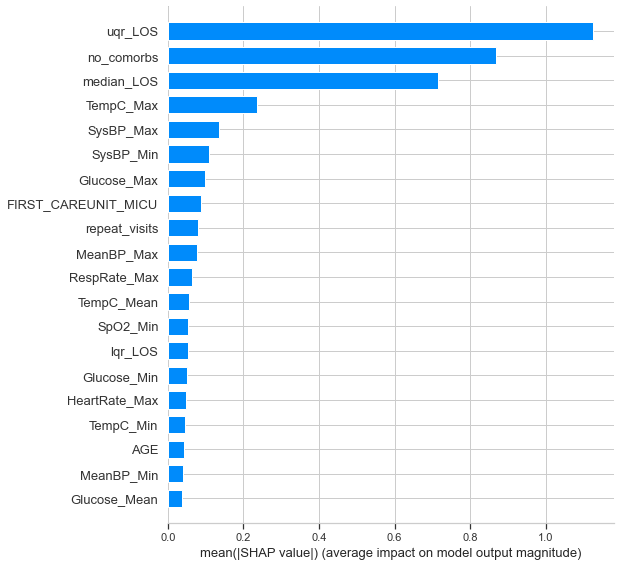

In [96]:
explainer = shap.TreeExplainer(best_model) #(***) xgb_model is my trained xgboost model 
shap_values = explainer.shap_values(interpretation_train)
shap.initjs()
shap.summary_plot(shap_values, interpretation_train, plot_type="bar")

[Text(0, 0, 'uqr_LOS'),
 Text(1, 0, 'no_comorbs'),
 Text(2, 0, 'median_LOS'),
 Text(3, 0, 'TempC_Max'),
 Text(4, 0, 'AGE'),
 Text(5, 0, 'SysBP_Max'),
 Text(6, 0, 'repeat_visits'),
 Text(7, 0, 'lqr_LOS'),
 Text(8, 0, 'TempC_Mean'),
 Text(9, 0, 'Glucose_Min'),
 Text(10, 0, 'HeartRate_Mean'),
 Text(11, 0, 'SpO2_Mean'),
 Text(12, 0, 'Glucose_Max'),
 Text(13, 0, 'MeanBP_Max'),
 Text(14, 0, 'RespRate_Mean'),
 Text(15, 0, 'SysBP_Min'),
 Text(16, 0, 'TempC_Min'),
 Text(17, 0, 'DiasBP_Mean'),
 Text(18, 0, 'Glucose_Mean'),
 Text(19, 0, 'SpO2_Min'),
 Text(20, 0, 'HeartRate_Max'),
 Text(21, 0, 'MeanBP_Mean'),
 Text(22, 0, 'SysBP_Mean'),
 Text(23, 0, 'HeartRate_Min'),
 Text(24, 0, 'RespRate_Max'),
 Text(25, 0, 'MeanBP_Min'),
 Text(26, 0, 'DiasBP_Max'),
 Text(27, 0, 'FIRST_CAREUNIT_MICU'),
 Text(28, 0, 'DiasBP_Min'),
 Text(29, 0, 'RespRate_Min'),
 Text(30, 0, 'min_LOS'),
 Text(31, 0, 'SpO2_Max'),
 Text(32, 0, 'FIRST_CAREUNIT_SICU'),
 Text(33, 0, 'FIRST_CAREUNIT_CSRU'),
 Text(34, 0, 'MARITAL_STATUS_M

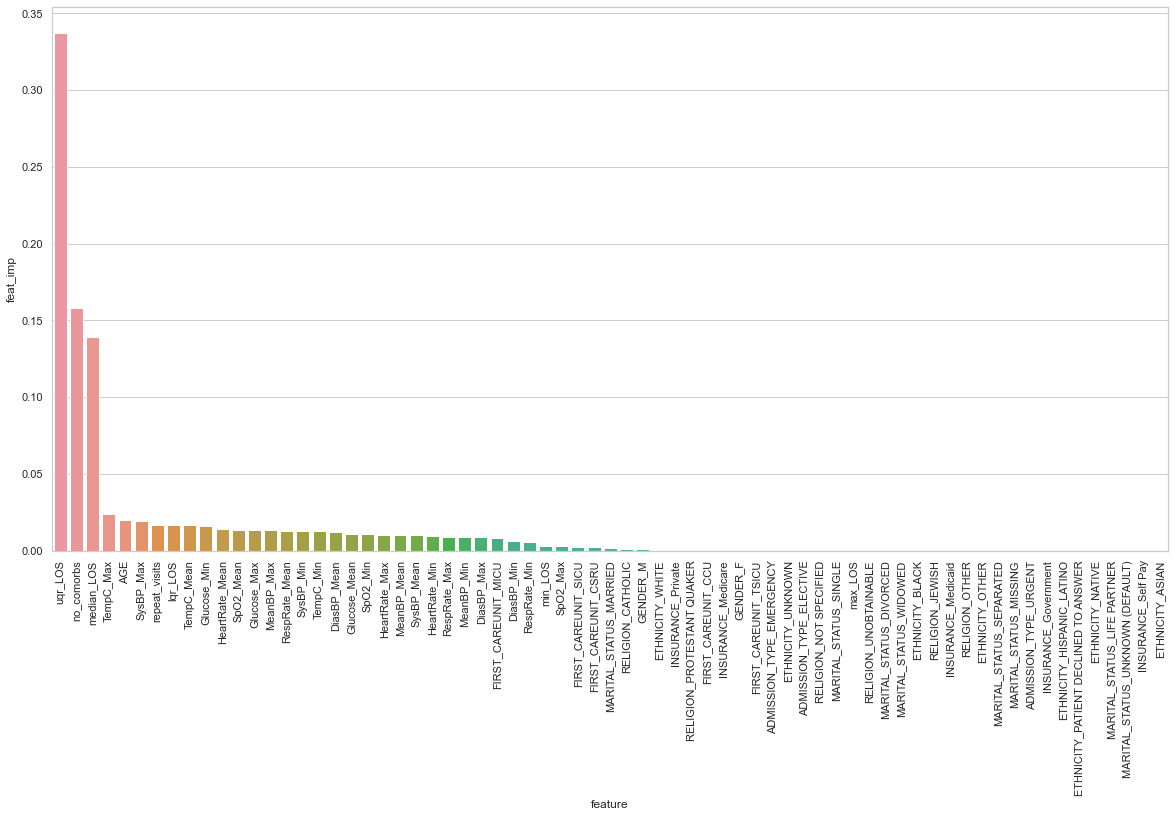

In [99]:
#compared to feature importance
#build dataframe
rf_imp = pd.DataFrame(zip(interpretation_train.columns, best_model.feature_importances_), columns=['feature','feat_imp'])
rf_imp.sort_values(by='feat_imp',ascending=False,inplace=True)
# plot
chart=sns.barplot(x='feature',y='feat_imp',data=rf_imp)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)


In fact, these do not look too different. Both Shap values and the feature importances from the model rank the upper quartile of LOS, no of comobiridities and median LOS as the most important features (by some distance). For a future purpose, this would provide a super useful way of informing feature propogations (you would definitely include these 3!). 

## Local interpretation

In [114]:
#I pick out the person with the longest length of stay in the dataset out of curiosity
y_train[y_train == max(y_train)]

15127    101.739
Name: LOS, dtype: float64

In [115]:
# Plot the explanation of one observation
mytarget = 15127

shap.initjs() 

shap.force_plot(explainer.expected_value, shap_values[mytarget,:], interpretation_train.iloc[mytarget,:])


In [120]:
#comparison of local intepretation to average value per feature
pd.DataFrame(zip(interpretation_train.columns,interpretation_train.mean(),interpretation_train.iloc[mytarget,:],shap_values[mytarget,:]),
             columns=['feature','avg_value','mytarget_value','shap_value']).sort_values(by='mytarget_value', ascending = False).head(10)

,feature,avg_value,mytarget_value,shap_value
30,uqr_LOS,0.256158,4.739914,13.213414
28,lqr_LOS,0.256108,3.984545,0.842294
29,median_LOS,0.224176,3.346206,3.668820
1,HeartRate_Max,0.074753,3.285714,0.228279
25,no_comorbs,0.083692,2.200000,5.137663
0,HeartRate_Min,0.031917,1.315789,-0.067750
6,DiasBP_Min,0.024602,1.285714,-0.013340
12,RespRate_Min,-0.017116,1.250000,-0.025288
2,HeartRate_Mean,0.045657,1.238207,0.002823
14,RespRate_Mean,0.123984,1.146909,0.490585


So for the individual with the longest stay, we see that, for example, their heart rate is having a larger effect on their length of stay relative to the average importance of this feature. This is quite intriguing, so I take a quick look at the heart rate value for this person relative to the overall distribution of heart rates in the data. 

In [124]:
interpretation_train[['HeartRate_Max', 'HeartRate_Min', 'HeartRate_Mean']].describe()

,HeartRate_Max,HeartRate_Min,HeartRate_Mean
count,20885.000000,20885.000000,20885.000000
mean,0.074753,0.031917,0.045657
std,0.710102,0.743692,0.696540
min,-2.285714,-3.526316,-2.362991
25%,-0.392857,-0.421053,-0.414560
50%,0.000000,0.000000,-0.006273
75%,0.464286,0.473684,0.460744
max,6.321429,3.789474,3.813147


In [125]:
interpretation_train.loc[15127, ['HeartRate_Max', 'HeartRate_Min', 'HeartRate_Mean']]

HeartRate_Max     3.285714
HeartRate_Min     1.315789
HeartRate_Mean    1.238207
Name: 15127, dtype: float64

Super interesting, their heart rate falls well into the upper quartile across all three metrics. 

## Summary

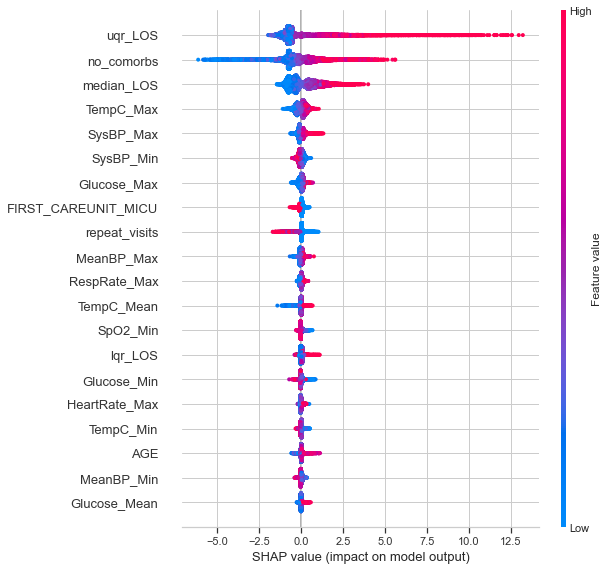

In [107]:
# summarize the effects of all the features
shap.summary_plot(shap_values, interpretation_train)

I agree, this is also my favourite plot. It really shows how important the upper quartile LOS feature was in contributing to longer average stays. 